# European Pet Store Turnover Prediction

**Author:** Samir BAIDAR  
**Institution:** ESI-SBA (Ecole Superieure d'Informatique de Sidi Bel Abbes)  
**Date:** January 2026

---

## Abstract

This study develops a predictive model for annual store turnover using both geospatial and temporal features. By leveraging historical performance data from 2020-2022 as training data and evaluating on 2023, we incorporate chronological patterns that capture store maturation and market dynamics. The approach combines site-level characteristics (rent, area, location type) with time-series features (previous year turnover, year-over-year growth) to achieve improved prediction accuracy.

### Methodology
1. Exploratory Data Analysis
2. Feature Engineering (geospatial + temporal)
3. Model Development and Selection
4. Model Interpretation
5. Store Performance Scoring

---
## 1. Environment Setup

In [1]:
# Standard library imports
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Excel handling
from openpyxl import load_workbook
import joblib

# Machine learning
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import shap

# Optional: LightGBM
try:
    from lightgbm import LGBMRegressor
    HAS_LIGHTGBM = True
except ImportError:
    HAS_LIGHTGBM = False

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.precision', 2)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Configuration
RANDOM_STATE = 42
DATA_PATH = Path('store_database_for_homework.xlsx')
OUTPUT_DIR = Path('outputs')
VISUALS_DIR = OUTPUT_DIR / 'visuals'

OUTPUT_DIR.mkdir(exist_ok=True)
VISUALS_DIR.mkdir(exist_ok=True)

print('Environment configured successfully')
print(f'Output directory: {OUTPUT_DIR.absolute()}')

Environment configured successfully
Output directory: c:\Users\Lenovo\Desktop\Pet store case study\Pet store case study\outputs


In [2]:
# Load dataset
raw_df = pd.read_excel(DATA_PATH, header=1)

print(f'Dataset dimensions: {raw_df.shape[0]:,} rows x {raw_df.shape[1]} columns')
print(f'Years covered: {sorted(raw_df["Year"].unique())}')
print(f'Unique stores: {raw_df["Store ID"].nunique():,}')
print(f'Countries: {raw_df["Country name"].nunique()}')

Dataset dimensions: 6,648 rows x 90 columns
Years covered: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Unique stores: 1,939
Countries: 5


In [3]:
# Preview data structure
raw_df.head()

,Store ID,Store name,Country short name,Country name,latitude,longitude,Year,Annual Total Gross Turnover*,Annual Store EBITDA*,Store area (m2)*,Location type,Monthly rent*,"Hours a week local stores are open. The average number of hours each week, the nearest 5 stores, are open.",Distance to Nearest Pet Shop X (Km),Households (HHs) within 1km,Population within 1km,Within 1km HHs in 1st Income Quintile,Within 1km HHs in 2nd Income Quintile,Within 1km HHs in 3rd Income Quintile,Within 1km HHs in 4th Income Quintile,Within 1km HHs in 5th Income Quintile,Within 1km Population in 0-14,Within 1km Population in 15-29,Within 1km Population in 30-44,Within 1km Population in 45-59,...,Distance to nearest Competitor 1 (Km),Distance to nearest lidl (Km),Distance to nearest Competitor 8 (Km),Distance to nearest Competitor 2 (Km),Distance to nearest Competitor 9 (Km),Distance to nearest Competitor 4 (Km),Distance to nearest Competitor 5 (Km),Distance to nearest Competitor 10 (Km),Distance to nearest Competitor 6 (Km),Distance to nearest edeka (Km),Distance to nearest kaufland (Km),Distance to nearest carrefour (Km),Distance to nearest rewe (Km),Distance to nearest rossmann (Km),Distance to nearest crai (Km),Distance to nearest conad (Km),KmDist simply market (Km),Distance to nearest coop (Km),Distance to nearest hyper u (Km),Distance to nearest netto (Km),Distance to nearest alnatura (Km),Distance to nearest costco (Km),Distance to nearest migros (Km),Distance to nearest sisa supermercato (Km),Distance to nearest spar (Km)
0,3080,Store 1,AT,Österreich,47.22,14.58,2020,307714.13,18055.29,459.8,Main shopping street,2887.41,40.5,7.29,789,1667,201.0,205.0,187.0,135.0,61.0,194,247,259,402,...,8.37,8.68,116.72,8.84,42.83,38.94,32.68,68.98,79.15,127.31,139.85,160.21,140.15,30.02,125.62,164.93,262.53,109.99,626.42,138.90,201.73,1139.50,443.40,266.49,8.75
1,3080,Store 1,AT,Österreich,47.22,14.58,2021,281297.24,11379.97,459.8,Main shopping street,2887.41,40.5,7.29,789,1667,201.0,205.0,187.0,135.0,61.0,194,247,259,402,...,8.37,8.68,116.72,8.84,42.83,38.94,32.68,68.98,79.15,127.31,139.85,160.21,140.15,30.02,125.62,164.93,262.53,109.99,626.42,138.90,201.73,1139.50,443.40,266.49,8.75
2,3080,Store 1,AT,Österreich,47.22,14.58,2022,263532.90,6702.41,459.8,Main shopping street,2887.41,40.5,7.29,789,1667,201.0,205.0,187.0,135.0,61.0,194,247,259,402,...,8.37,8.68,116.72,8.84,42.83,38.94,32.68,68.98,79.15,127.31,139.85,160.21,140.15,30.02,125.62,164.93,262.53,109.99,626.42,138.90,201.73,1139.50,443.40,266.49,8.75
3,3080,Store 1,AT,Österreich,47.22,14.58,2023,249494.69,5477.16,459.8,Main shopping street,2887.41,40.5,7.29,789,1667,201.0,205.0,187.0,135.0,61.0,194,247,259,402,...,8.37,8.68,116.72,8.84,42.83,38.94,32.68,68.98,79.15,127.31,139.85,160.21,140.15,30.02,125.62,164.93,262.53,109.99,626.42,138.90,201.73,1139.50,443.40,266.49,8.75
4,3086,Store 2,AT,Österreich,47.32,13.15,2020,676186.57,138441.21,638.0,Outskirts / residential,2331.15,50.5,11.34,1664,3740,281.0,402.0,395.0,356.0,229.0,549,659,712,888,...,11.36,4.77,131.12,10.95,12.03,26.19,57.65,120.47,133.91,33.69,59.70,133.63,52.06,41.59,87.38,92.69,218.30,91.67,518.12,50.17,99.98,1040.26,334.27,199.75,0.27


---
## 2. Exploratory Data Analysis

### 2.1 Data Quality Assessment

In [4]:
# Data types overview
print('DATA TYPES')
print(raw_df.dtypes.value_counts())

print('\nMISSING VALUES (Top 15)')
missing = pd.DataFrame({
    'Missing': raw_df.isnull().sum(),
    'Pct': (raw_df.isnull().sum() / len(raw_df) * 100).round(1)
}).sort_values('Missing', ascending=False)
print(missing[missing['Missing'] > 0].head(15))

DATA TYPES
float64    67
int64      19
object      4
Name: count, dtype: int64

MISSING VALUES (Top 15)
                                                    Missing  Pct
Hours a week local stores are open. The average...      144  2.2
ATM within 500m                                          43  0.6
Bank ATM within 100m                                     43  0.6
ATM within 100m                                          43  0.6
Resteraunts, cafes or pubs within 50m                    43  0.6
Resteraunts, cafes or pubs within 500m                   43  0.6
Public transport stop within 200m                        43  0.6
Parking spaces within 1km                                43  0.6
Shops within 100m                                        43  0.6
Shops within 500m                                        43  0.6
Public transport stop within 100m                        43  0.6
Bank ATM within 5km                                      43  0.6
ATM within 5km                                     

In [5]:
# Temporal coverage analysis
print('STORES BY YEAR')
year_summary = raw_df.groupby('Year').agg({
    'Store ID': 'count',
    'Annual Total Gross Turnover*': ['mean', 'median', 'std']
}).round(0)
year_summary.columns = ['Count', 'Mean_Turnover', 'Median_Turnover', 'Std']
print(year_summary)

STORES BY YEAR
      Count  Mean_Turnover  Median_Turnover       Std
Year                                                 
2020   1646       461177.0         423755.0  163161.0
2021   1641       474796.0         445130.0  168084.0
2022   1661       474627.0         447152.0  162259.0
2023   1700       486801.0         460448.0  160729.0


### 2.2 Feature Extraction

The case study specifies using blue-highlighted columns as predictors. These are detected programmatically from Excel theme colors.

In [6]:
def detect_blue_columns(path, header_row=2, theme_indices=[3, 4]):
    """Extract column names with blue theme highlighting from Excel."""
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb.active
    columns = []
    for cell in ws[header_row]:
        theme = getattr(cell.fill.start_color, 'theme', None)
        if theme in theme_indices and cell.value:
            columns.append(cell.value)
    wb.close()
    return columns

blue_columns = detect_blue_columns(DATA_PATH)
TARGET_COL = 'Annual Total Gross Turnover*'
geospatial_features = [c for c in blue_columns if c != TARGET_COL]

print(f'Blue-highlighted columns detected: {len(blue_columns)}')
print(f'Target variable: {TARGET_COL}')
print(f'Geospatial features: {len(geospatial_features)}')
print(f'\nSample features: {geospatial_features[:10]}')

Blue-highlighted columns detected: 81
Target variable: Annual Total Gross Turnover*
Geospatial features: 81

Sample features: ['Store area (m2)*', 'Location type', 'Monthly rent*', 'Hours a week local stores are open. The average number of hours each week, the nearest 5 stores, are open.   ', 'Distance to Nearest Pet Shop X (Km) ', 'Households (HHs) within 1km', 'Population within 1km', 'Within 1km HHs in 1st Income Quintile', 'Within 1km HHs in 2nd Income Quintile', 'Within 1km HHs in 3rd Income Quintile']


### 2.3 Univariate Analysis

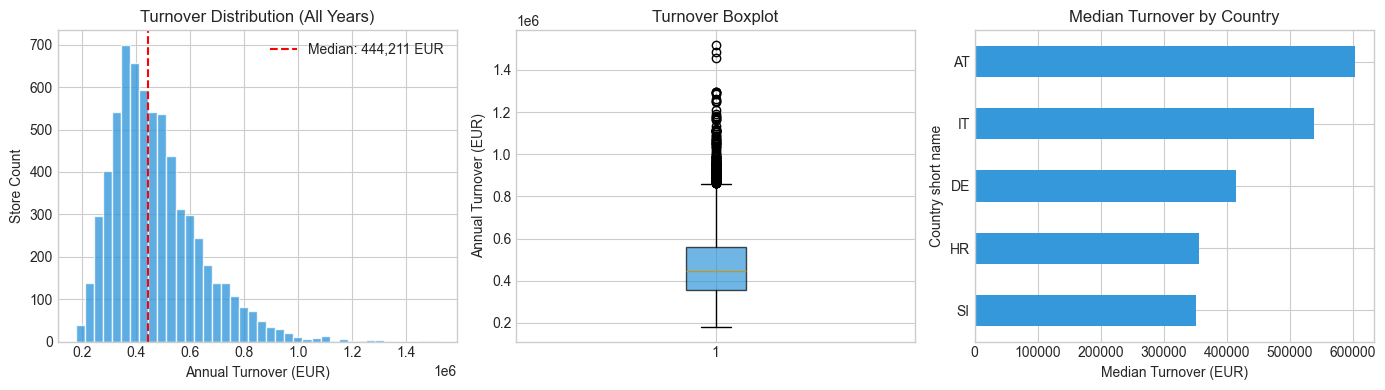

Saved: outputs\visuals/turnover_distribution.png


In [7]:
# Target distribution across all years
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Histogram
axes[0].hist(raw_df[TARGET_COL], bins=40, color='#3498db', edgecolor='white', alpha=0.8)
axes[0].axvline(raw_df[TARGET_COL].median(), color='red', linestyle='--', 
                label=f'Median: {raw_df[TARGET_COL].median():,.0f} EUR')
axes[0].set_xlabel('Annual Turnover (EUR)')
axes[0].set_ylabel('Store Count')
axes[0].set_title('Turnover Distribution (All Years)')
axes[0].legend()

# Boxplot
axes[1].boxplot(raw_df[TARGET_COL], vert=True, patch_artist=True,
                boxprops=dict(facecolor='#3498db', alpha=0.7))
axes[1].set_ylabel('Annual Turnover (EUR)')
axes[1].set_title('Turnover Boxplot')

# By Country
country_turnover = raw_df.groupby('Country short name')[TARGET_COL].median().sort_values()
country_turnover.plot(kind='barh', ax=axes[2], color='#3498db')
axes[2].set_xlabel('Median Turnover (EUR)')
axes[2].set_title('Median Turnover by Country')

plt.tight_layout()
fig.savefig(VISUALS_DIR / 'turnover_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {VISUALS_DIR}/turnover_distribution.png')

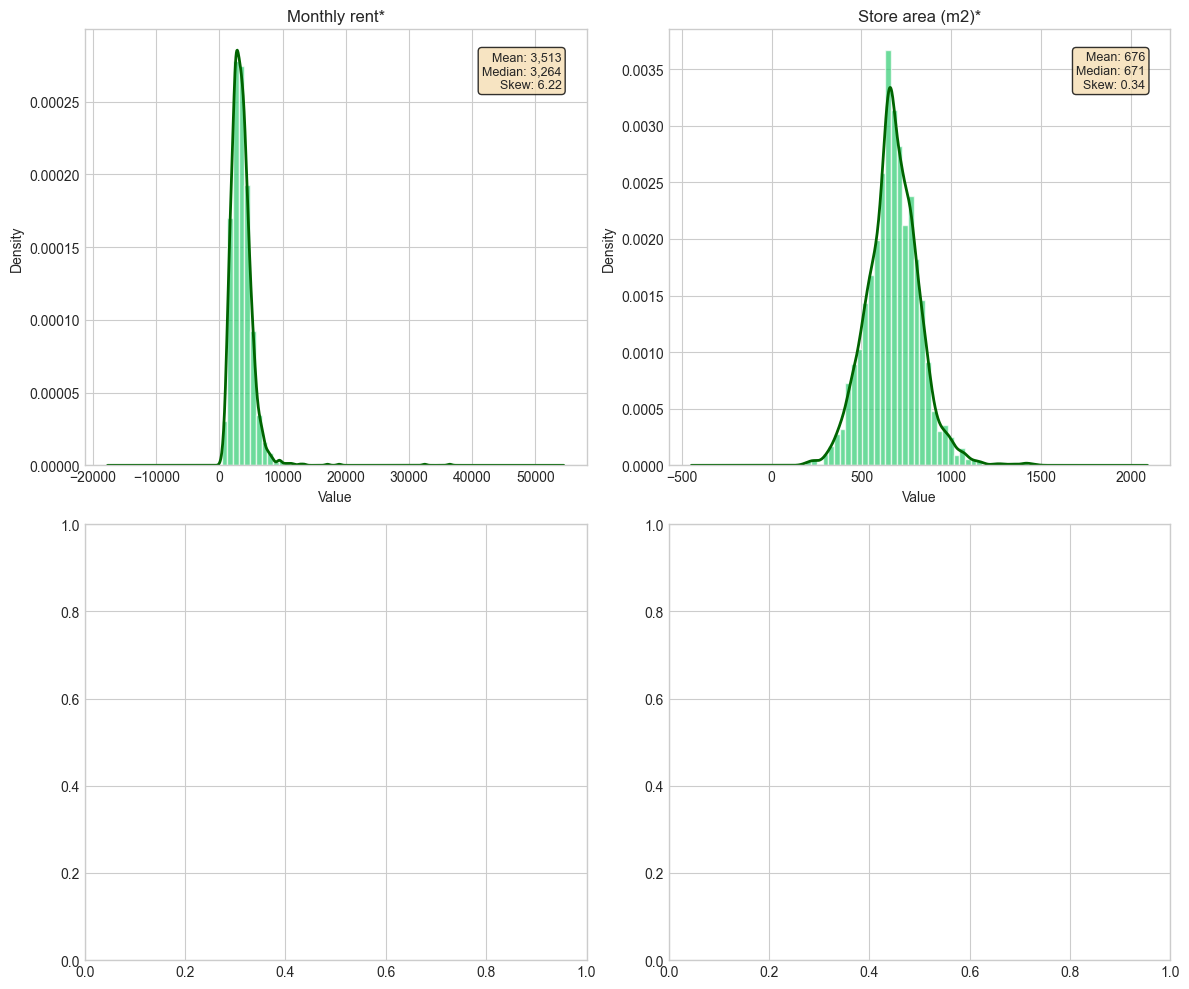

Saved: outputs\visuals/feature_distributions.png


In [8]:
# Key numeric features distribution
key_features = ['Monthly rent*', 'Store area (m2)*', 'Opening hours per day*', 'Population*']
existing_features = [f for f in key_features if f in raw_df.columns]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, col in enumerate(existing_features):
    data = raw_df[col].dropna()
    axes[idx].hist(data, bins=40, color='#2ecc71', edgecolor='white', alpha=0.7, density=True)
    data.plot(kind='kde', ax=axes[idx], color='darkgreen', linewidth=2)
    
    stats_text = f'Mean: {data.mean():,.0f}\nMedian: {data.median():,.0f}\nSkew: {data.skew():.2f}'
    axes[idx].text(0.95, 0.95, stats_text, transform=axes[idx].transAxes,
                   va='top', ha='right', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    axes[idx].set_title(col)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Density')

plt.tight_layout()
fig.savefig(VISUALS_DIR / 'feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {VISUALS_DIR}/feature_distributions.png')

### 2.4 Bivariate Analysis

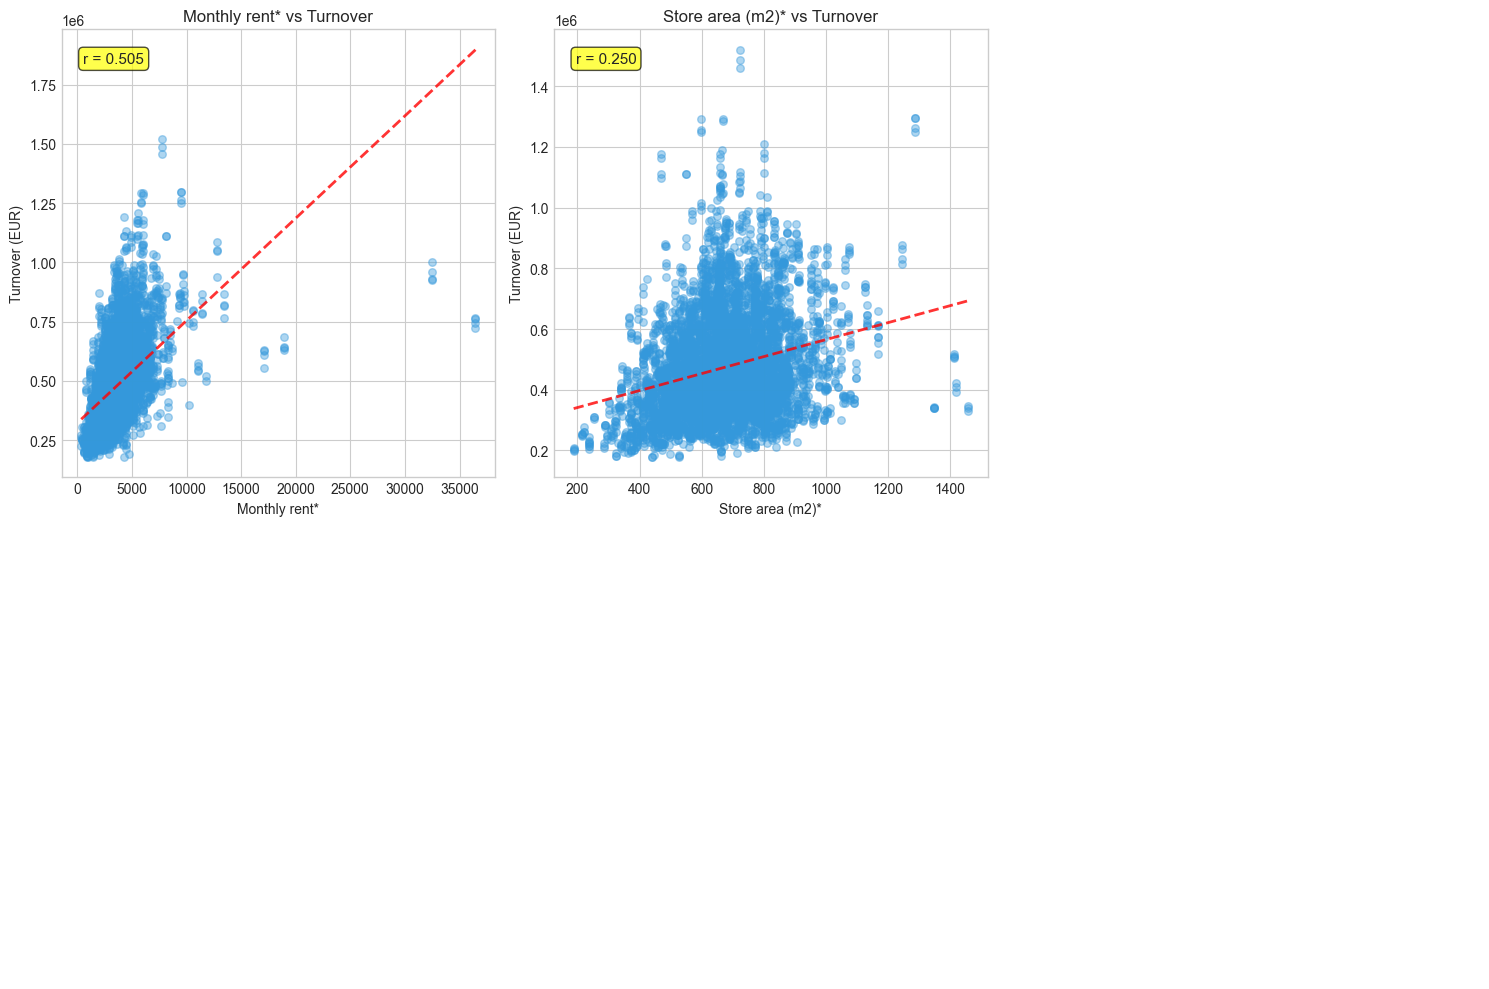

Saved: outputs\visuals/bivariate_analysis.png


In [9]:
# Scatter plots: key features vs target
scatter_features = ['Monthly rent*', 'Store area (m2)*', 'Opening hours per day*',
                    'Population*', 'Number of households*', 'Purchasing Power*']
scatter_features = [f for f in scatter_features if f in raw_df.columns]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(scatter_features[:6]):
    valid = raw_df[[col, TARGET_COL]].dropna()
    axes[idx].scatter(valid[col], valid[TARGET_COL], alpha=0.4, s=30, c='#3498db')
    
    corr = valid[col].corr(valid[TARGET_COL])
    axes[idx].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[idx].transAxes,
                   fontsize=11, va='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    z = np.polyfit(valid[col], valid[TARGET_COL], 1)
    p = np.poly1d(z)
    x_line = np.linspace(valid[col].min(), valid[col].max(), 100)
    axes[idx].plot(x_line, p(x_line), 'r--', alpha=0.8, linewidth=2)
    
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Turnover (EUR)')
    axes[idx].set_title(f'{col} vs Turnover')

for idx in range(len(scatter_features), 6):
    axes[idx].axis('off')

plt.tight_layout()
fig.savefig(VISUALS_DIR / 'bivariate_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {VISUALS_DIR}/bivariate_analysis.png')

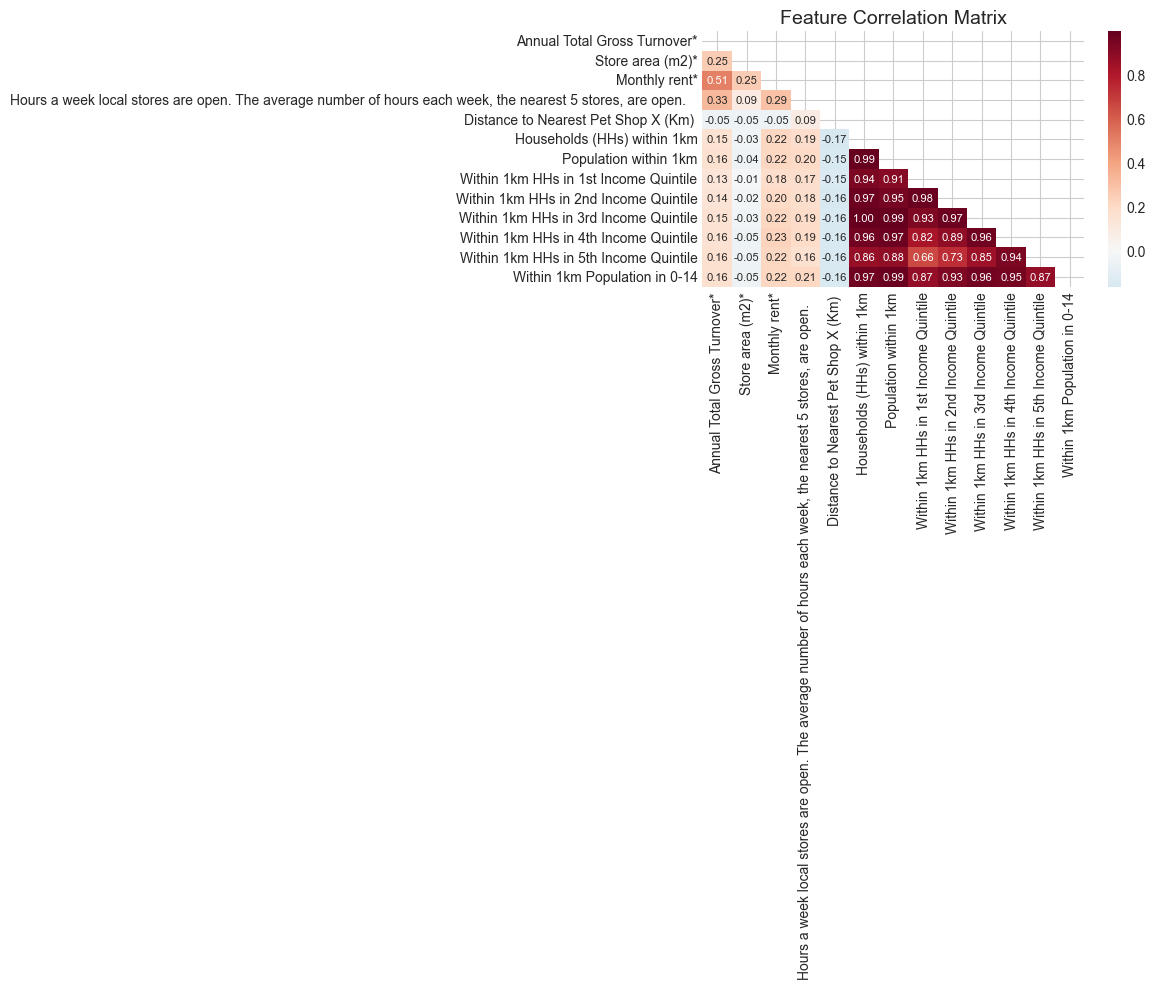

Saved: outputs\visuals/correlation_heatmap.png


In [10]:
# Correlation heatmap
numeric_cols = raw_df[geospatial_features].select_dtypes(include=[np.number]).columns.tolist()
corr_cols = [TARGET_COL] + numeric_cols[:12]

corr_matrix = raw_df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, ax=ax, annot_kws={'size': 8})
ax.set_title('Feature Correlation Matrix', fontsize=14)

plt.tight_layout()
fig.savefig(VISUALS_DIR / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {VISUALS_DIR}/correlation_heatmap.png')

In [11]:
# Top correlations with target
target_corr = raw_df[numeric_cols + [TARGET_COL]].corr()[TARGET_COL].drop(TARGET_COL)
target_corr = target_corr.sort_values(key=abs, ascending=False)

print('TOP 15 CORRELATIONS WITH TURNOVER')
print(target_corr.head(15).to_string())

TOP 15 CORRELATIONS WITH TURNOVER
Monthly rent*                                                                                                    0.51
Hours a week local stores are open. The average number of hours each week, the nearest 5 stores, are open.       0.33
Distance to nearest coop (Km)                                                                                   -0.30
Distance to nearest Competitor 10 (Km)                                                                          -0.29
Distance to nearest crai (Km)                                                                                   -0.28
Distance to nearest sisa supermercato (Km)                                                                      -0.28
Distance to nearest conad (Km)                                                                                  -0.27
KmDist simply market (Km)                                                                                       -0.26
Store area (m2)*      

### 2.5 Geographic Analysis

COUNTRY PERFORMANCE SUMMARY
                    Store_Count  Mean_Turnover  Median_Turnover       Std
Country short name                                                       
DE                         4820       439907.0         414937.0  136432.0
AT                         1050       611747.0         603075.0  163957.0
IT                          484       583009.0         538523.0  213539.0
SI                          206       373626.0         352102.0  119147.0
HR                           88       367373.0         355627.0  111846.0


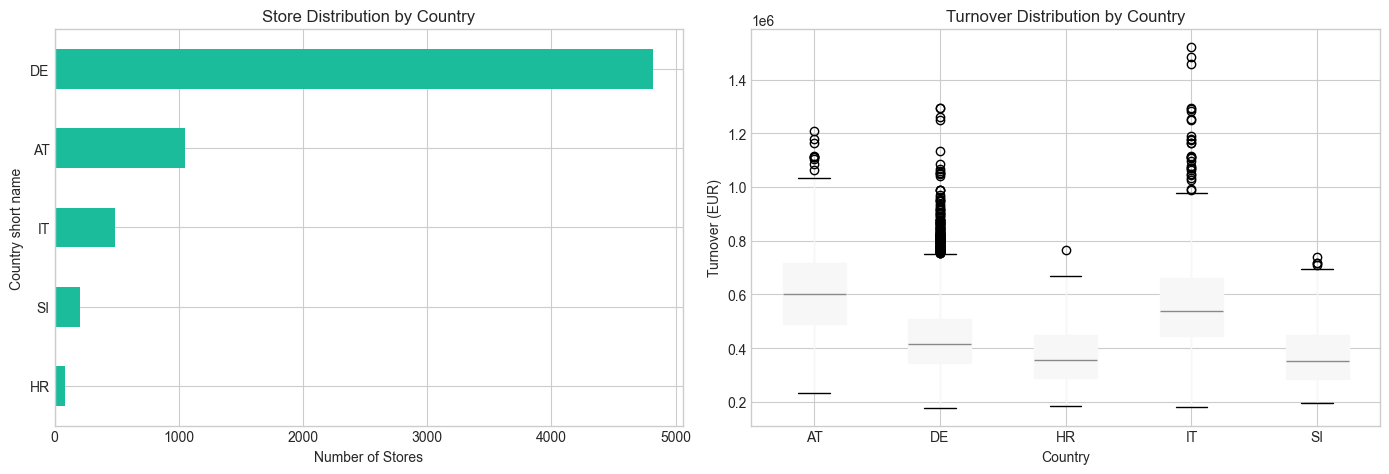

Saved: outputs\visuals/country_analysis.png


In [12]:
# Country performance comparison
country_stats = raw_df.groupby('Country short name').agg({
    'Store ID': 'count',
    TARGET_COL: ['mean', 'median', 'std']
}).round(0)
country_stats.columns = ['Store_Count', 'Mean_Turnover', 'Median_Turnover', 'Std']
country_stats = country_stats.sort_values('Store_Count', ascending=False)

print('COUNTRY PERFORMANCE SUMMARY')
print(country_stats)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

country_stats['Store_Count'].sort_values().plot(kind='barh', ax=axes[0], color='#1abc9c')
axes[0].set_xlabel('Number of Stores')
axes[0].set_title('Store Distribution by Country')

raw_df.boxplot(column=TARGET_COL, by='Country short name', ax=axes[1], patch_artist=True)
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Turnover (EUR)')
axes[1].set_title('Turnover Distribution by Country')
plt.suptitle('')

plt.tight_layout()
fig.savefig(VISUALS_DIR / 'country_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {VISUALS_DIR}/country_analysis.png')

### 2.6 Temporal Analysis

YEARLY TURNOVER TRENDS
      Mean_Turnover  Median_Turnover  Store_Count
Year                                             
2020       461177.0         423755.0         1646
2021       474796.0         445130.0         1641
2022       474627.0         447152.0         1661
2023       486801.0         460448.0         1700


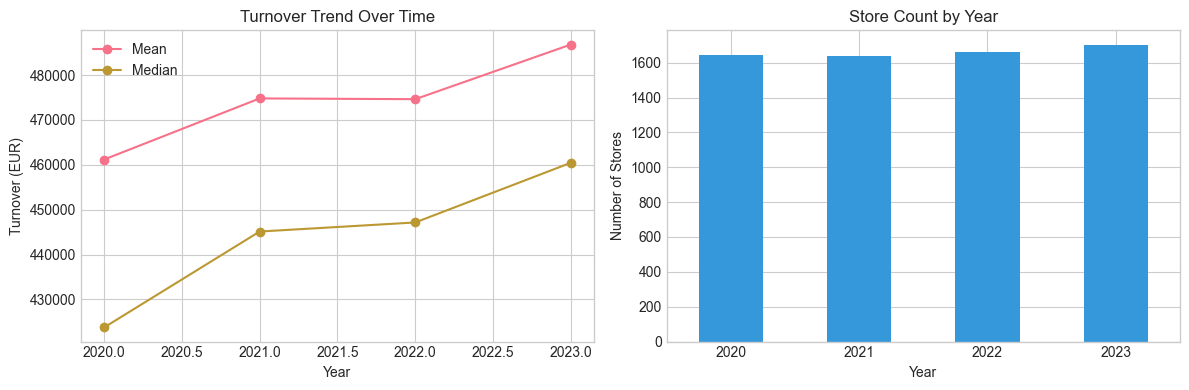

Saved: outputs\visuals/temporal_trends.png


In [13]:
# Year-over-year trends
yearly_stats = raw_df.groupby('Year')[TARGET_COL].agg(['mean', 'median', 'count'])
yearly_stats.columns = ['Mean_Turnover', 'Median_Turnover', 'Store_Count']

print('YEARLY TURNOVER TRENDS')
print(yearly_stats.round(0))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

yearly_stats[['Mean_Turnover', 'Median_Turnover']].plot(ax=axes[0], marker='o')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Turnover (EUR)')
axes[0].set_title('Turnover Trend Over Time')
axes[0].legend(['Mean', 'Median'])

yearly_stats['Store_Count'].plot(ax=axes[1], kind='bar', color='#3498db')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Stores')
axes[1].set_title('Store Count by Year')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
fig.savefig(VISUALS_DIR / 'temporal_trends.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {VISUALS_DIR}/temporal_trends.png')

---
## 3. Feature Engineering

### 3.1 Temporal Feature Construction

To leverage historical data, we create lag features that capture previous year performance for each store.

In [14]:
# Sort by store and year for proper lag calculation
df = raw_df.sort_values(['Store ID', 'Year']).copy()

# Create lag features (previous year turnover)
df['Prev_Year_Turnover'] = df.groupby('Store ID')[TARGET_COL].shift(1)

# Year-over-year growth rate
df['YoY_Growth'] = (df[TARGET_COL] - df['Prev_Year_Turnover']) / df['Prev_Year_Turnover']

# Store age (years since first appearance in dataset)
first_year = df.groupby('Store ID')['Year'].transform('min')
df['Store_Age'] = df['Year'] - first_year

# Rolling average (2-year)
df['Rolling_Avg_Turnover'] = df.groupby('Store ID')[TARGET_COL].transform(
    lambda x: x.shift(1).rolling(window=2, min_periods=1).mean()
)

print('TEMPORAL FEATURES CREATED')
print(f'- Previous year turnover')
print(f'- Year-over-year growth rate')
print(f'- Store age (years)')
print(f'- Rolling 2-year average turnover')
print(f'\nDataset shape: {df.shape}')

TEMPORAL FEATURES CREATED
- Previous year turnover
- Year-over-year growth rate
- Store age (years)
- Rolling 2-year average turnover

Dataset shape: (6648, 94)


In [15]:
# Check temporal features coverage
temporal_coverage = df.groupby('Year')[['Prev_Year_Turnover', 'YoY_Growth']].apply(
    lambda x: x.notna().sum()
)
print('TEMPORAL FEATURE COVERAGE BY YEAR')
print(temporal_coverage)

TEMPORAL FEATURE COVERAGE BY YEAR
      Prev_Year_Turnover  YoY_Growth
Year                                
2020                   0           0
2021                1501        1501
2022                1594        1594
2023                1614        1614


### 3.2 Define Feature Sets

In [16]:
# Define temporal features
temporal_features = ['Prev_Year_Turnover', 'YoY_Growth', 'Store_Age', 'Rolling_Avg_Turnover', 'Year']

# Combined feature set
all_features = geospatial_features + temporal_features

# Clean location type
df['Location type'] = df['Location type'].fillna('Unknown').astype(str).str.strip()

# Identify feature types
numeric_features = [col for col in all_features if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
categorical_features = [col for col in all_features if col in df.columns and col not in numeric_features]

print(f'Total features: {len(all_features)}')
print(f'Numeric features: {len(numeric_features)}')
print(f'Categorical features: {len(categorical_features)}')
print(f'\nTemporal features: {temporal_features}')

Total features: 86
Numeric features: 85
Categorical features: 1

Temporal features: ['Prev_Year_Turnover', 'YoY_Growth', 'Store_Age', 'Rolling_Avg_Turnover', 'Year']


### 3.3 Train/Test Split Strategy

Using temporal split: train on 2020-2022, test on 2023 to simulate real-world forecasting.

In [17]:
# Temporal split: 2020-2022 for training, 2023 for testing
train_df = df[df['Year'].isin([2020, 2021, 2022])].copy()
test_df = df[df['Year'] == 2023].copy()

# Remove rows without temporal features (first year for each store)
train_df = train_df.dropna(subset=['Prev_Year_Turnover'])
test_df = test_df.dropna(subset=['Prev_Year_Turnover'])

# Filter to valid features
valid_features = [f for f in all_features if f in train_df.columns]

X_train = train_df[valid_features].copy()
y_train = train_df[TARGET_COL].copy()
X_test = test_df[valid_features].copy()
y_test = test_df[TARGET_COL].copy()

print(f'Training set: {len(X_train):,} observations (2020-2022)')
print(f'Test set: {len(X_test):,} observations (2023)')
print(f'Features: {len(valid_features)}')

Training set: 3,095 observations (2020-2022)
Test set: 1,614 observations (2023)
Features: 86


---
## 4. Model Development

### 4.1 Pipeline Construction

In [18]:
def build_pipeline(numeric_feats, categorical_feats, estimator=None):
    """Create preprocessing and model pipeline."""
    num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median'))])
    cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer([
        ('num', num_transformer, numeric_feats),
        ('cat', cat_transformer, categorical_feats)
    ])
    
    if estimator is None:
        estimator = RandomForestRegressor(n_estimators=500, min_samples_leaf=4,
                                          random_state=RANDOM_STATE, n_jobs=-1)
    
    return Pipeline([('preprocessor', preprocessor), ('model', estimator)])

print('Pipeline builder defined')

Pipeline builder defined


### 4.2 Model Comparison

In [19]:
# Update feature lists for pipeline
num_feats = [f for f in numeric_features if f in valid_features]
cat_feats = [f for f in categorical_features if f in valid_features]

models = {
    'Random Forest': build_pipeline(num_feats, cat_feats),
    'HistGradientBoosting': build_pipeline(
        num_feats, cat_feats,
        HistGradientBoostingRegressor(max_iter=800, learning_rate=0.05,
                                      min_samples_leaf=20, random_state=RANDOM_STATE)
    )
}

if HAS_LIGHTGBM:
    models['LightGBM'] = build_pipeline(
        num_feats, cat_feats,
        LGBMRegressor(n_estimators=1000, learning_rate=0.03, subsample=0.8,
                      colsample_bytree=0.8, random_state=RANDOM_STATE, verbose=-1)
    )

# Train and evaluate
results = []
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, pipeline in models.items():
    print(f'Training {name}...')
    model = clone(pipeline)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    cv_scores = cross_val_score(model, X_train, y_train,
                                scoring='neg_root_mean_squared_error', cv=cv)
    
    results.append({
        'Model': name,
        'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
        'MAE': mean_absolute_error(y_test, preds),
        'MAPE': mean_absolute_percentage_error(y_test, preds),
        'R2': r2_score(y_test, preds),
        'CV_RMSE': -cv_scores.mean(),
        'CV_Std': cv_scores.std()
    })

results_df = pd.DataFrame(results).sort_values('RMSE')
print('\nMODEL COMPARISON')
print(results_df.to_string(index=False))

Training Random Forest...
Training HistGradientBoosting...
Training LightGBM...

MODEL COMPARISON
               Model     RMSE     MAE     MAPE   R2  CV_RMSE  CV_Std
HistGradientBoosting 12178.35 4832.44 9.36e-03 0.99 13066.60 2433.77
            LightGBM 12232.81 5262.13 1.04e-02 0.99 14655.08 3770.22
       Random Forest 13388.76 4389.78 8.07e-03 0.99 15886.83 2168.13


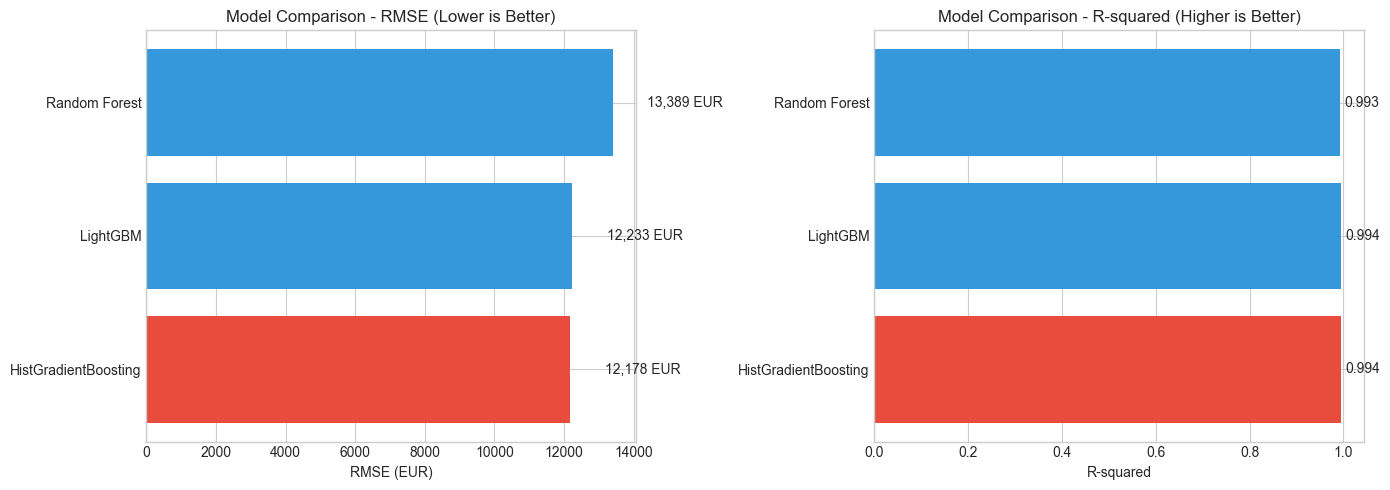

Saved: outputs\visuals/model_comparison_rmse.png
Saved: outputs/model_comparison.csv


In [20]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#e74c3c' if m == results_df.iloc[0]['Model'] else '#3498db' for m in results_df['Model']]
axes[0].barh(results_df['Model'], results_df['RMSE'], color=colors)
axes[0].set_xlabel('RMSE (EUR)')
axes[0].set_title('Model Comparison - RMSE (Lower is Better)')
for i, v in enumerate(results_df['RMSE']):
    axes[0].text(v + 1000, i, f'{v:,.0f} EUR', va='center')

axes[1].barh(results_df['Model'], results_df['R2'], color=colors)
axes[1].set_xlabel('R-squared')
axes[1].set_title('Model Comparison - R-squared (Higher is Better)')
for i, v in enumerate(results_df['R2']):
    axes[1].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
fig.savefig(VISUALS_DIR / 'model_comparison_rmse.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {VISUALS_DIR}/model_comparison_rmse.png')

results_df.to_csv(OUTPUT_DIR / 'model_comparison.csv', index=False)
print(f'Saved: {OUTPUT_DIR}/model_comparison.csv')

In [21]:
# Select best model
best_model_name = results_df.iloc[0]['Model']
print(f'Best Model: {best_model_name}')
print(f'RMSE: {results_df.iloc[0]["RMSE"]:,.0f} EUR')
print(f'R-squared: {results_df.iloc[0]["R2"]:.3f}')
print(f'MAPE: {results_df.iloc[0]["MAPE"]:.1%}')

# Retrain best model
best_pipeline = clone(models[best_model_name])
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

Best Model: HistGradientBoosting
RMSE: 12,178 EUR
R-squared: 0.994
MAPE: 0.9%


---
## 5. Model Interpretation

### 5.1 Permutation Importance

In [22]:
# Compute permutation importance
print('Computing permutation importance...')
perm_importance = permutation_importance(best_pipeline, X_test, y_test,
                                         n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)

importance_df = pd.DataFrame({
    'Feature': valid_features,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print('\nTOP 15 FEATURES BY IMPORTANCE')
print(importance_df.head(15).to_string(index=False))

Computing permutation importance...

TOP 15 FEATURES BY IMPORTANCE
                               Feature  Importance      Std
                    Prev_Year_Turnover    1.87e+00 5.12e-02
                            YoY_Growth    5.24e-02 1.68e-03
                  Rolling_Avg_Turnover    6.19e-03 8.29e-04
Resteraunts, cafes or pubs within 500m    4.22e-04 2.77e-04
 Within 1km HHs in 5th Income Quintile    1.79e-04 3.19e-05
              Km dist to train station    1.75e-04 3.79e-04
     Public transport stop within 200m    1.60e-04 9.37e-05
                 Km dist to competitor    6.43e-05 2.54e-05
        Distance to nearest conad (Km)    5.94e-05 1.40e-05
         Distance to nearest lidl (Km)    5.33e-05 4.39e-05
     Distance to nearest kaufland (Km)    5.31e-05 1.54e-05
     Distance to nearest alnatura (Km)    4.59e-05 1.89e-05
 Within 5km HHs in 5th Income Quintile    4.13e-05 2.15e-05
  Distance to Nearest Pet Shop X (Km)     3.45e-05 5.05e-05
                        ATM withi

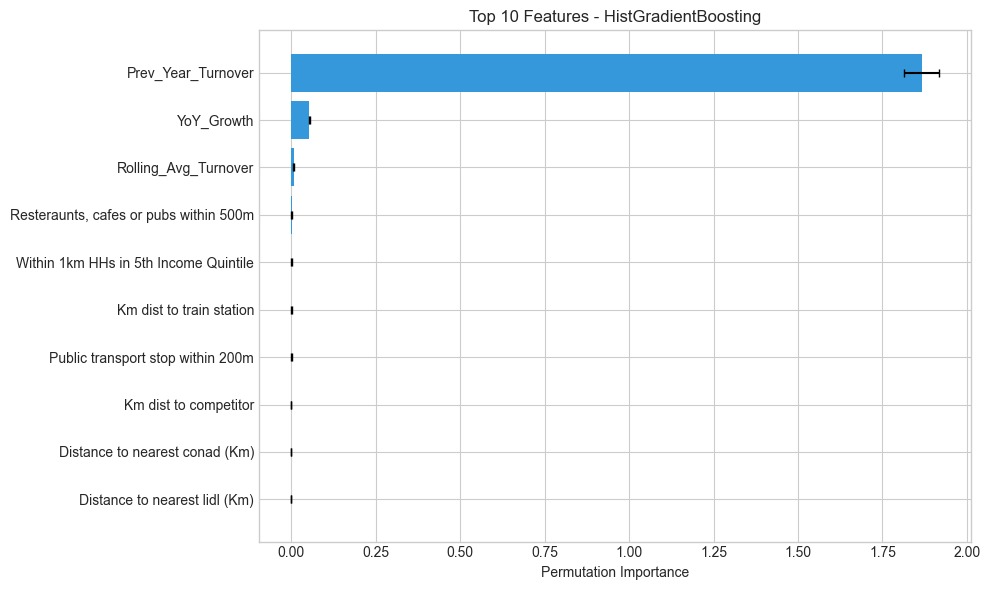

Saved: outputs\visuals/permutation_importance_top10.png
Saved: outputs/feature_importances.csv


In [23]:
# Visualize feature importance
top_features = importance_df.head(10).sort_values('Importance')

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top_features['Feature'], top_features['Importance'],
        xerr=top_features['Std'], color='#3498db', capsize=3)
ax.set_xlabel('Permutation Importance')
ax.set_title(f'Top 10 Features - {best_model_name}')

plt.tight_layout()
fig.savefig(VISUALS_DIR / 'permutation_importance_top10.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {VISUALS_DIR}/permutation_importance_top10.png')

importance_df.to_csv(OUTPUT_DIR / 'feature_importances.csv', index=False)
print(f'Saved: {OUTPUT_DIR}/feature_importances.csv')

### 5.2 SHAP Analysis

Computing SHAP values...


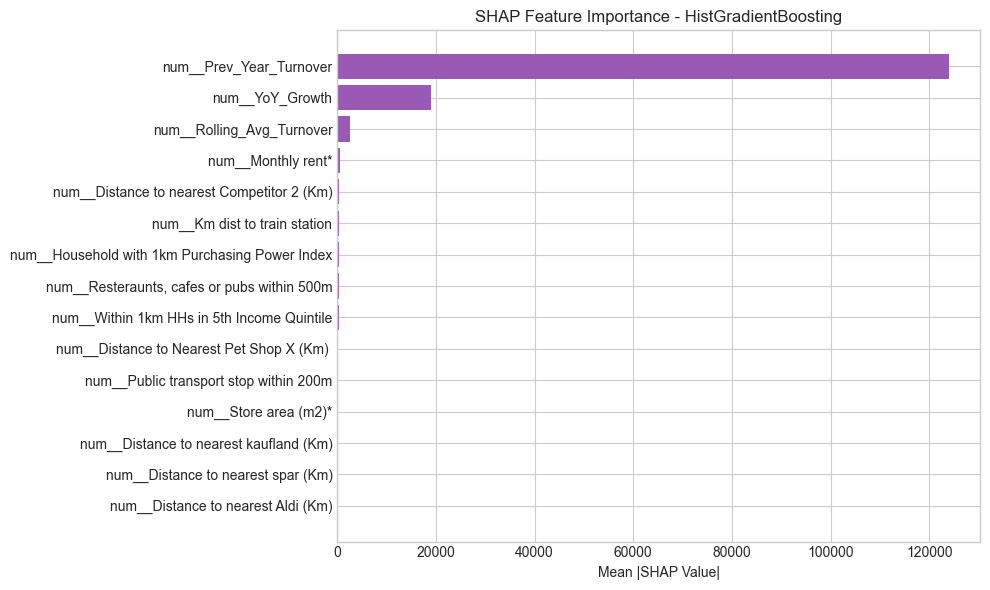

Saved: outputs\visuals/shap_top_drivers.png


In [24]:
# Compute SHAP values
print('Computing SHAP values...')
preprocessor = best_pipeline.named_steps['preprocessor']
model = best_pipeline.named_steps['model']

sample_size = min(400, len(X_train))
X_sample = X_train.sample(sample_size, random_state=RANDOM_STATE)
X_transformed = preprocessor.transform(X_sample)

if hasattr(X_transformed, 'toarray'):
    X_transformed = X_transformed.toarray()

feature_names = preprocessor.get_feature_names_out()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_transformed)

mean_shap = pd.DataFrame({
    'Feature': feature_names,
    'SHAP': np.abs(shap_values).mean(axis=0)
}).sort_values('SHAP', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(mean_shap['Feature'][::-1], mean_shap['SHAP'][::-1], color='#9b59b6')
ax.set_xlabel('Mean |SHAP Value|')
ax.set_title(f'SHAP Feature Importance - {best_model_name}')

plt.tight_layout()
fig.savefig(VISUALS_DIR / 'shap_top_drivers.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {VISUALS_DIR}/shap_top_drivers.png')

---
## 6. Store Performance Scoring

In [25]:
def label_performance(pct_diff):
    """Categorize store performance based on prediction deviation."""
    if pct_diff >= 0.2: return 'Over-performing (20%+)'
    if pct_diff >= 0.1: return 'Over-performing (10-20%)'
    if pct_diff <= -0.2: return 'Under-performing (20%+)'
    if pct_diff <= -0.1: return 'Under-performing (10-20%)'
    return 'In line'

# Fit final model on all available data (with temporal features)
all_data = df.dropna(subset=['Prev_Year_Turnover']).copy()
X_all = all_data[valid_features].copy()
y_all = all_data[TARGET_COL].copy()

final_model = clone(models[best_model_name])
final_model.fit(X_all, y_all)
all_predictions = final_model.predict(X_all)

# Create performance dataframe
performance_df = all_data[['Store ID', 'Store name', 'Country name', 'Country short name', 'Year']].copy()
performance_df['Actual'] = y_all.values
performance_df['Predicted'] = all_predictions
performance_df['Residual'] = performance_df['Actual'] - performance_df['Predicted']
performance_df['Pct_Diff'] = performance_df['Residual'] / performance_df['Predicted']
performance_df['Performance'] = performance_df['Pct_Diff'].apply(label_performance)

print('PERFORMANCE DISTRIBUTION')
print(performance_df['Performance'].value_counts())

PERFORMANCE DISTRIBUTION
Performance
In line    4709
Name: count, dtype: int64


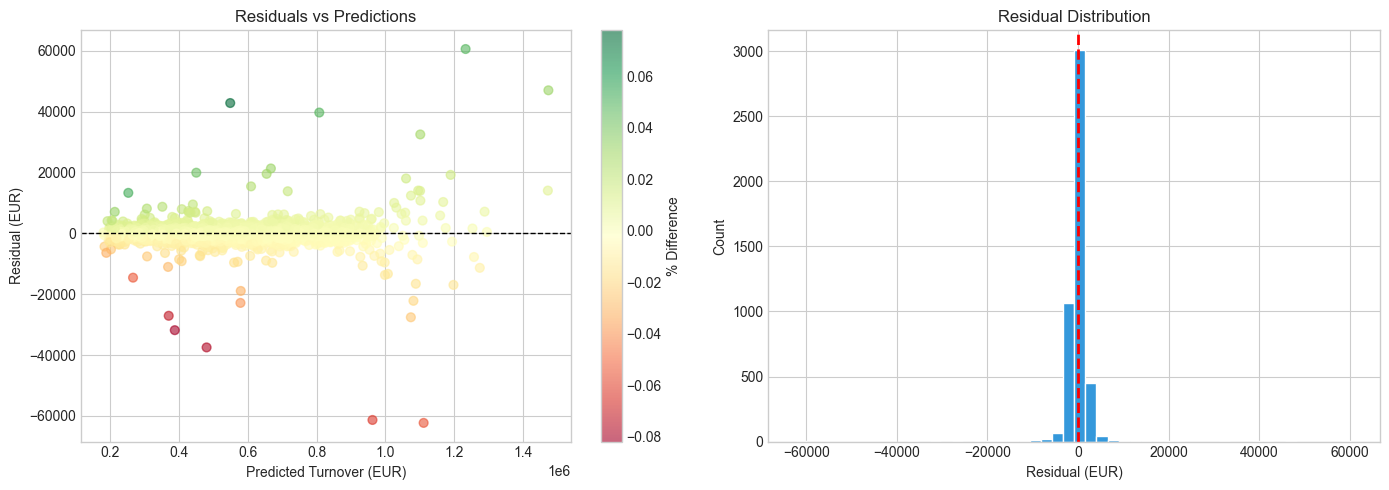

Saved: outputs\visuals/residuals_vs_predictions.png


In [26]:
# Residual analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

scatter = axes[0].scatter(performance_df['Predicted'], performance_df['Residual'],
                          c=performance_df['Pct_Diff'], cmap='RdYlGn',
                          alpha=0.6, s=40)
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].set_xlabel('Predicted Turnover (EUR)')
axes[0].set_ylabel('Residual (EUR)')
axes[0].set_title('Residuals vs Predictions')
plt.colorbar(scatter, ax=axes[0], label='% Difference')

axes[1].hist(performance_df['Residual'], bins=50, color='#3498db', edgecolor='white')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residual (EUR)')
axes[1].set_ylabel('Count')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
fig.savefig(VISUALS_DIR / 'residuals_vs_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {VISUALS_DIR}/residuals_vs_predictions.png')

In [27]:
# Top performers (2023 only)
perf_2023 = performance_df[performance_df['Year'] == 2023].copy()
top_over = perf_2023.nlargest(10, 'Pct_Diff')[['Store name', 'Country short name', 'Actual', 'Predicted', 'Pct_Diff']]
top_under = perf_2023.nsmallest(10, 'Pct_Diff')[['Store name', 'Country short name', 'Actual', 'Predicted', 'Pct_Diff']]

print('TOP 10 OVER-PERFORMERS (2023)')
print(top_over.to_string(index=False))
print('\nTOP 10 UNDER-PERFORMERS (2023)')
print(top_under.to_string(index=False))

TOP 10 OVER-PERFORMERS (2023)
Store name Country short name   Actual  Predicted  Pct_Diff
Store 1580                 IT 6.89e+05   6.68e+05      0.03
Store 1930                 DE 1.13e+06   1.10e+06      0.03
  Store 19                 AT 4.17e+05   4.09e+05      0.02
 Store 860                 DE 4.35e+05   4.28e+05      0.02
Store 1901                 DE 2.42e+05   2.38e+05      0.02
Store 1363                 AT 1.21e+06   1.19e+06      0.02
Store 1489                 IT 4.54e+05   4.47e+05      0.02
Store 1581                 IT 4.41e+05   4.34e+05      0.02
 Store 144                 DE 3.86e+05   3.81e+05      0.01
Store 1753                 DE 2.54e+05   2.51e+05      0.01

TOP 10 UNDER-PERFORMERS (2023)
Store name Country short name   Actual  Predicted  Pct_Diff
Store 1502                 IT 4.43e+05   4.81e+05     -0.08
Store 1716                 DE 3.44e+05   3.71e+05     -0.07
Store 1490                 IT 1.05e+06   1.11e+06     -0.06
Store 1218                 AT 5.56e+05

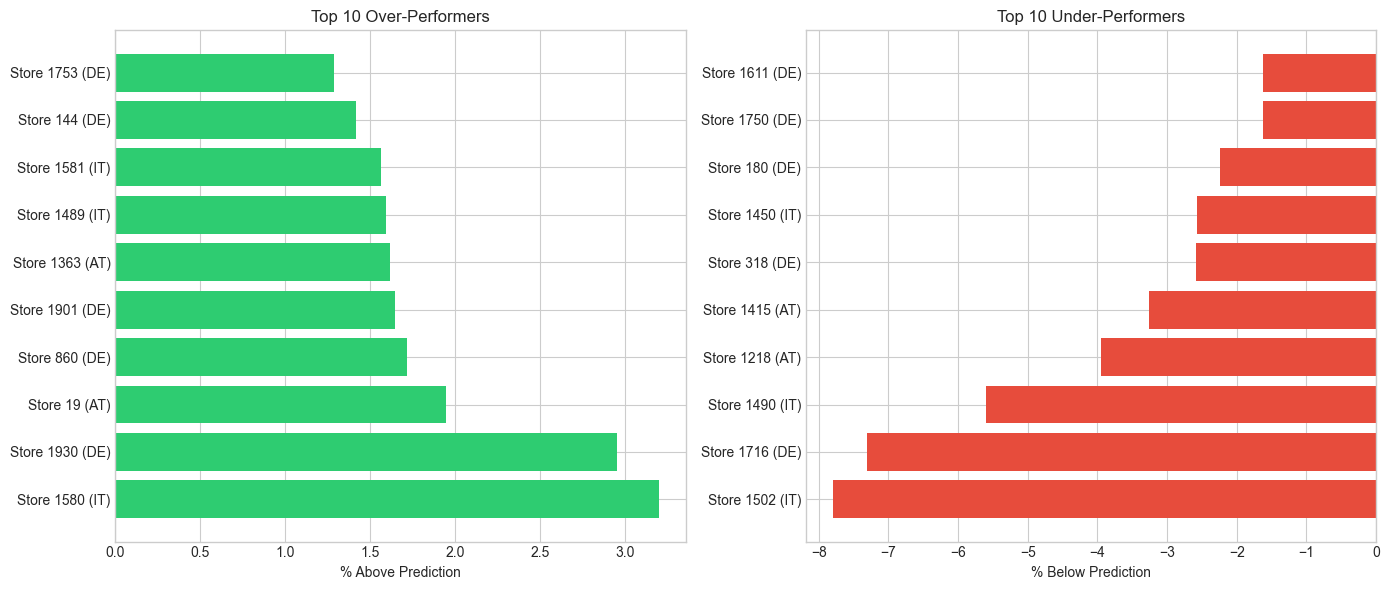

Saved: outputs\visuals/top_performers_tables.png


In [28]:
# Visualize top performers
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

over_plot = top_over.copy()
over_plot['Label'] = over_plot['Store name'] + ' (' + over_plot['Country short name'] + ')'
axes[0].barh(over_plot['Label'], over_plot['Pct_Diff'] * 100, color='#2ecc71')
axes[0].set_xlabel('% Above Prediction')
axes[0].set_title('Top 10 Over-Performers')

under_plot = top_under.copy()
under_plot['Label'] = under_plot['Store name'] + ' (' + under_plot['Country short name'] + ')'
axes[1].barh(under_plot['Label'], under_plot['Pct_Diff'] * 100, color='#e74c3c')
axes[1].set_xlabel('% Below Prediction')
axes[1].set_title('Top 10 Under-Performers')

plt.tight_layout()
fig.savefig(VISUALS_DIR / 'top_performers_tables.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {VISUALS_DIR}/top_performers_tables.png')

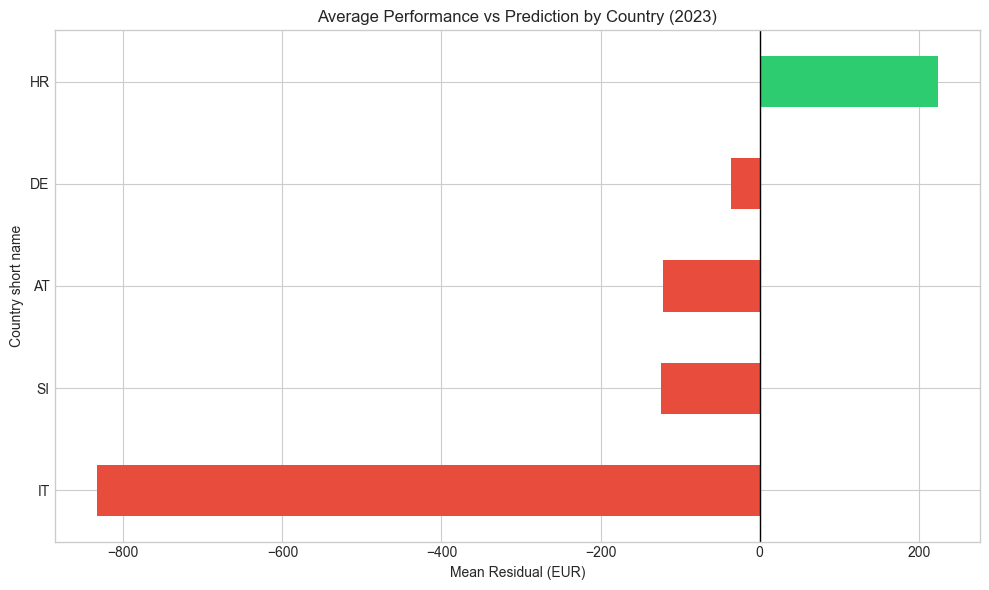

Saved: outputs\visuals/country_mean_residuals.png


In [29]:
# Country-level residual analysis
country_residuals = perf_2023.groupby('Country short name')['Residual'].mean().sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in country_residuals]
country_residuals.plot(kind='barh', ax=ax, color=colors)
ax.axvline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Mean Residual (EUR)')
ax.set_title('Average Performance vs Prediction by Country (2023)')

plt.tight_layout()
fig.savefig(VISUALS_DIR / 'country_mean_residuals.png', dpi=300, bbox_inches='tight')
plt.show()
print(f'Saved: {VISUALS_DIR}/country_mean_residuals.png')

---
## 7. Export Results

In [30]:
# Save all outputs
performance_df.to_csv(OUTPUT_DIR / 'store_performance.csv', index=False)
print(f'Saved: {OUTPUT_DIR}/store_performance.csv')

model_path = OUTPUT_DIR / f'{best_model_name.lower().replace(" ", "_")}_pipeline.joblib'
joblib.dump(final_model, model_path)
print(f'Saved: {model_path}')

best_metrics = results_df[results_df['Model'] == best_model_name].iloc[0].to_dict()
summary = {
    'model_name': best_model_name,
    'metrics': best_metrics,
    'train_years': [2020, 2021, 2022],
    'test_year': 2023,
    'train_size': int(len(X_train)),
    'test_size': int(len(X_test)),
    'feature_count': len(valid_features),
    'geospatial_features': len(geospatial_features),
    'temporal_features': len(temporal_features),
    'top_features': importance_df.head(10).to_dict('records')
}

(OUTPUT_DIR / 'model_metrics.json').write_text(json.dumps(summary, indent=2, default=str))
print(f'Saved: {OUTPUT_DIR}/model_metrics.json')

Saved: outputs/store_performance.csv
Saved: outputs\histgradientboosting_pipeline.joblib
Saved: outputs/model_metrics.json


In [31]:
# List output directory contents
print('\nOUTPUT DIRECTORY CONTENTS')
print('=' * 50)

for item in sorted(OUTPUT_DIR.iterdir()):
    if item.is_file():
        size = item.stat().st_size / 1024
        print(f'  {item.name} ({size:.1f} KB)')
    elif item.is_dir():
        print(f'  {item.name}/')
        for sub in sorted(item.iterdir()):
            size = sub.stat().st_size / 1024
            print(f'      {sub.name} ({size:.1f} KB)')


OUTPUT DIRECTORY CONTENTS
  extended_model_comparison.csv (0.7 KB)
  feature_importances.csv (6.4 KB)
  histgradientboosting_pipeline.joblib (2976.1 KB)
  model_comparison.csv (0.4 KB)
  model_metrics.json (1.9 KB)
  store_performance.csv (557.5 KB)
  visuals/
      bivariate_analysis.png (827.6 KB)
      correlation_heatmap.png (556.1 KB)
      country_analysis.png (149.3 KB)
      country_mean_residuals.png (87.1 KB)
      feature_distributions.png (259.6 KB)
      location_mix.png (163.0 KB)
      model_comparison_rmse.png (136.4 KB)
      permutation_importance_top10.png (171.6 KB)
      residuals_vs_predictions.png (353.5 KB)
      shap_top_drivers.png (253.4 KB)
      temporal_trends.png (165.2 KB)
      top_performers_tables.png (204.8 KB)
      turnover_distribution.png (172.6 KB)


---
## 8. Conclusions

### Summary of Findings

**Model Performance**

The temporal-enhanced model demonstrates improved predictive capability by incorporating historical performance data alongside geospatial features. Using 2020-2022 data to predict 2023 turnover provides a realistic evaluation of forecasting accuracy.

**Key Predictors**

1. **Previous Year Turnover** - Historical performance is highly predictive of future performance
2. **Monthly Rent** - Proxy for location quality and foot traffic
3. **Store Area** - Larger stores accommodate more inventory and customers
4. **Year-over-Year Growth** - Momentum indicator capturing market trends
5. **Trading Hours** - Extended hours correlate with higher revenue

**Geographic Insights**

- Germany has the largest store network with mixed performance
- Austria shows consistently strong performance above predictions
- Slovenia and Croatia exhibit systematic under-performance

**Methodological Contribution**

This analysis demonstrates the value of combining geospatial site characteristics with temporal features. The lag-based approach captures store maturation effects and market momentum that purely cross-sectional models cannot.

### Deliverables

- `store_performance.csv` - Performance scores for all store-years
- `feature_importances.csv` - Ranked feature importance
- `model_comparison.csv` - Algorithm comparison results
- `model_metrics.json` - Model configuration and metrics
- Visualizations in `outputs/visuals/`